<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/JustWickU3Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [3]:
# import required libraries
import preliz as pz
import pymc as pm # for model
import arviz as az # for plot of posterior
import numpy as np # for data array

# Traffic Deaths
The goal of this project is to predict the number of traffic deaths in the United States next year. This is interesting because traffic deaths are a major cause of preventable death in the U.S. Despite declining rates of death and crashes in peer countries, U.S. rates have remained relatively stable over the past few decades, so it is an important area for us to improve.

### Data
The data is the number of traffic deaths per year from 2000 to 2022 according to the National Highway Traffic Safety Administration.

In [4]:
data = np.array([
    41945, 42196, 43005, 42884, 42836, 43510, 42708, 41259, 37423, 33883,
    32999, 32479, 33782, 32893, 32744, 35485, 37806, 37473, 36835, 36355,
    38824, 43230, 42514])

The first model I tried uses a normal likelihood two uniform priors. I chose these because my data is quite similar to a uniform distribution, and I decided that a normal would be a good starting point for the likelihood.

Output()

Output()

Output()

<Axes: xlabel='Y'>

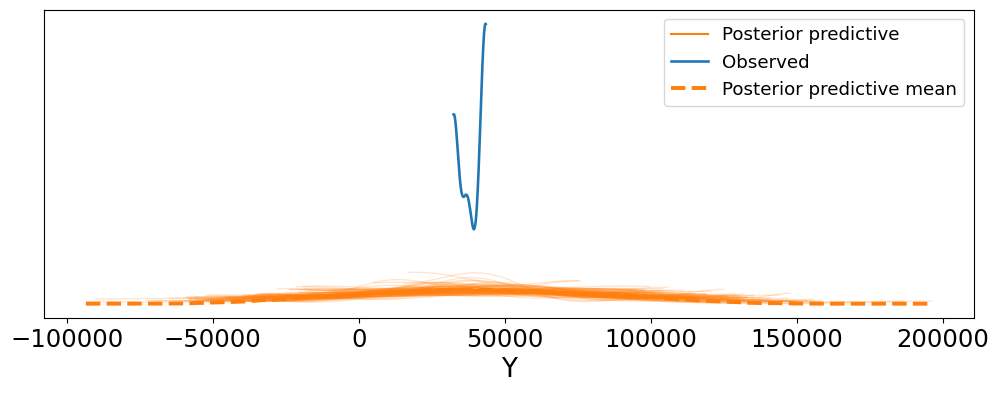

In [5]:
with pm.Model() as model: # model with two uniform priors and a normal likelihood
    μ = pm.Uniform('μ', lower=36000, upper=44000)

    σ = pm.Uniform('σ', lower=40000, upper=44000)

    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True) # sample from the posterior predictve
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]) # plot result

This result has two main problems. First, it includes negative values as a possibility, and it is impossible for there to be negative traffic deaths. Second, it includes too many extreme outliers. The chance of 100,000 traffic deaths (or some similar number) in a year is negligible, so the model should not give them such a high probability. In response, I changed one prior to a half-normal, which will eliminate negative values and reduce outliers.

Output()

Output()

Output()

<Axes: xlabel='Y'>

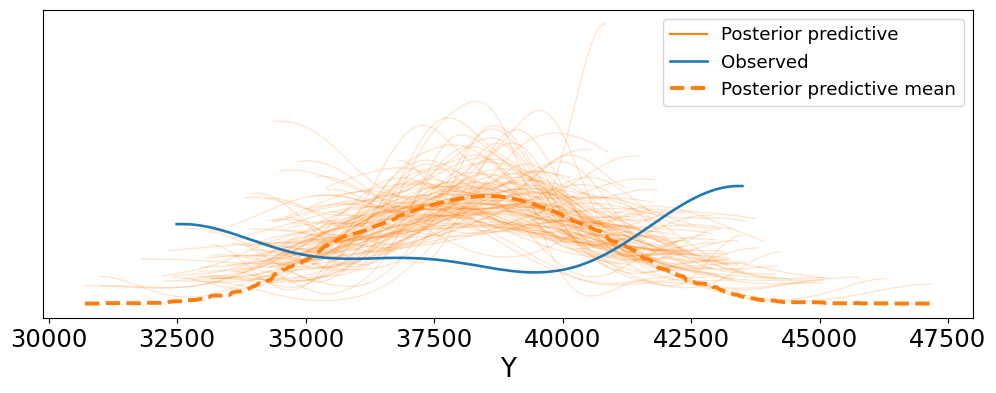

In [6]:
with pm.Model() as model: # same model as before but with one prior changed to a half-normal
    μ = pm.Uniform('μ', lower=36000, upper=42000)

    σ = pm.HalfNormal('σ', sigma=300)

    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This result is much better, but it still doesn't fit the data especially well. Next, I tried changing the normal prior to a truncated normal to eliminate the long tails with low probability (because the data suggests that the lower and higher ends do not have probability than the middle).

Output()

Output()

Output()

<Axes: xlabel='Y'>

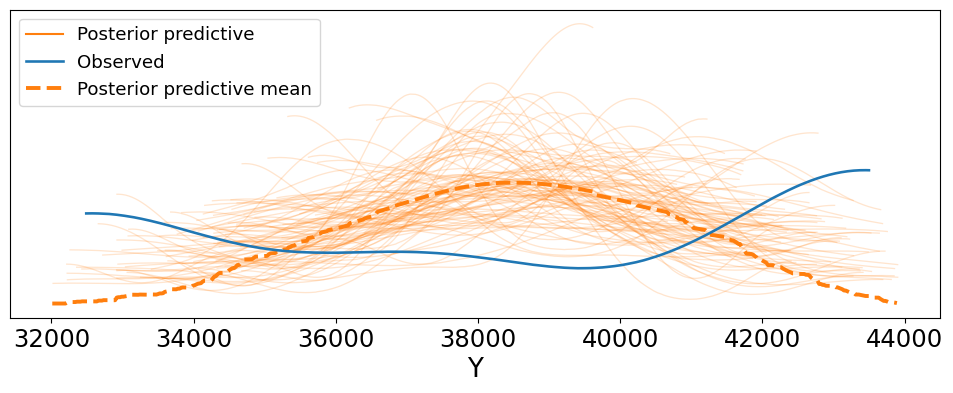

In [7]:
with pm.Model() as model: # likelihood changed to truncated normal from normal
    μ = pm.Uniform('μ', lower=36000, upper=42000)

    σ = pm.HalfNormal('σ', sigma=300)

    Y = pm.TruncatedNormal('Y', mu=μ, sigma=σ, lower=32000, upper=44000, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I had hoped that this would change the shape of the posterior predictive mean more, but it essentially only cut off the ends. Despite this making it closer to the data, I don't think it is better. There should be a resonably good chance that the number of traffic deaths is the highest or lowest in the past 23 years. I think that the model must allow for values lower or higher than all of the data, but not vastly lower or higher because traffic deaths generally change fairly slowly from year to year. Therefore, I broadened the domain of the truncated normal. Additionally, I changed my half-normal prior to a gamma because I thought it would produce a flatter overall distribution.

Output()

Output()

Output()

<Axes: xlabel='Y'>

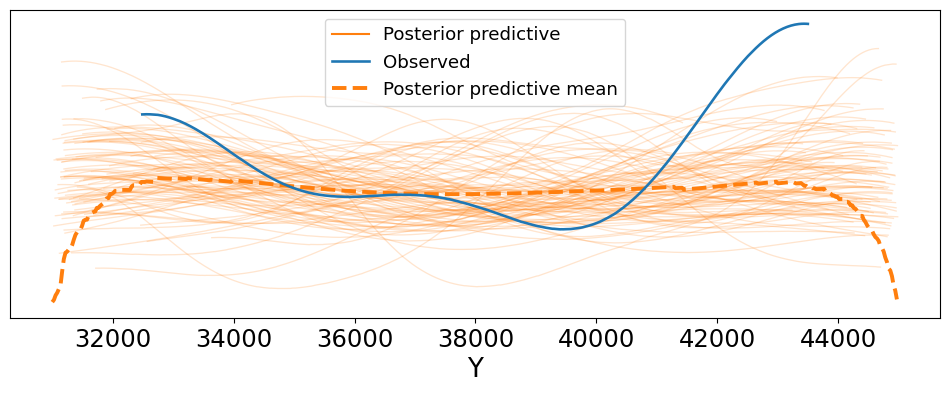

In [8]:
with pm.Model() as model: # changed half-normal prior to gamma
    μ = pm.Uniform('μ', lower=42000, upper=44000)

    σ = pm.Gamma('σ', alpha=44000000, beta=1000)

    Y = pm.TruncatedNormal('Y', mu=μ, sigma=σ, lower=31000, upper=45000, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

While I think this model is not terrible, I decided to try going back to the half-normal and uniform priors with different input values.

Output()

Output()

Output()

<Axes: xlabel='Y'>

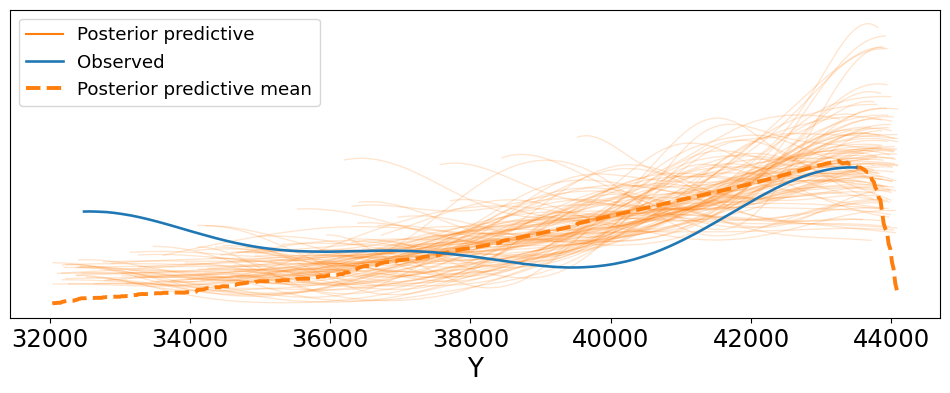

In [35]:
with pm.Model() as model: # return to the previous truncated normal likelihood with half-normal and uniform priors
    μ = pm.Uniform('μ', lower=44000, upper=52000) # shifted both bounds up

    σ = pm.HalfNormal('σ', sigma=900) # changed sigma

    Y = pm.TruncatedNormal('Y', mu=μ, sigma=σ, lower=32000, upper=44100, observed=data) # unchanged
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I think this model is the best I have produced. It has a larger amount of years with more deaths and fewer with less, but a sharp drop off after 45,000. Looking at the different posterior predictive results (the thin orange lines), I think most of them are plausible given the context, so I think this model is  quite good overall.

This is influenced by so many differing things, including vehicle designs, road designs, regulations, modal share, and more. Most of these things have changed over the 23 years of data and vary across the country. This leads to an odd shape for the data which was difficult to model

I also tried other model and priors, none of which were as good as this one. I have included some of them below:

Output()

Output()

Output()

<Axes: xlabel='Y'>

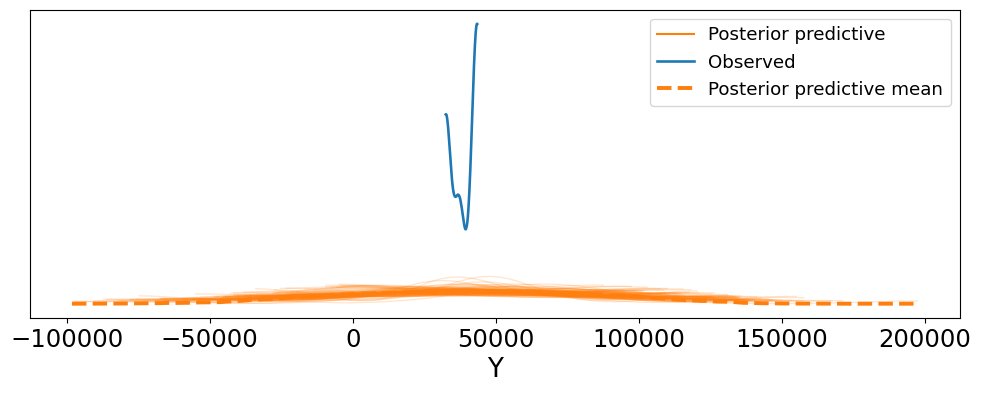

In [9]:
with pm.Model() as model: # same as my final model but with non-truncated normal
    μ = pm.Uniform('μ', lower=42000, upper=44000)

    σ = pm.Gamma('σ', alpha=44000000, beta=1000)

    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='Y'>

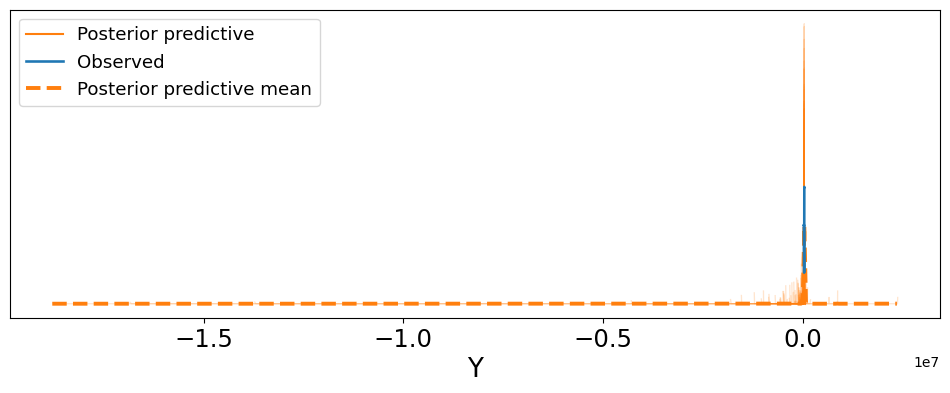

In [10]:
with pm.Model() as model: # another likelihood I tried
    μ = pm.Uniform('μ', lower=36000, upper=42000)

    σ = pm.HalfNormal('σ', sigma=300)

    a = pm.HalfNormal('a', sigma=300)
    b = pm.HalfNormal('b', sigma=300)

    Y = pm.SkewStudentT('Y', mu = μ, sigma = σ, a=a, b=b, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='Y'>

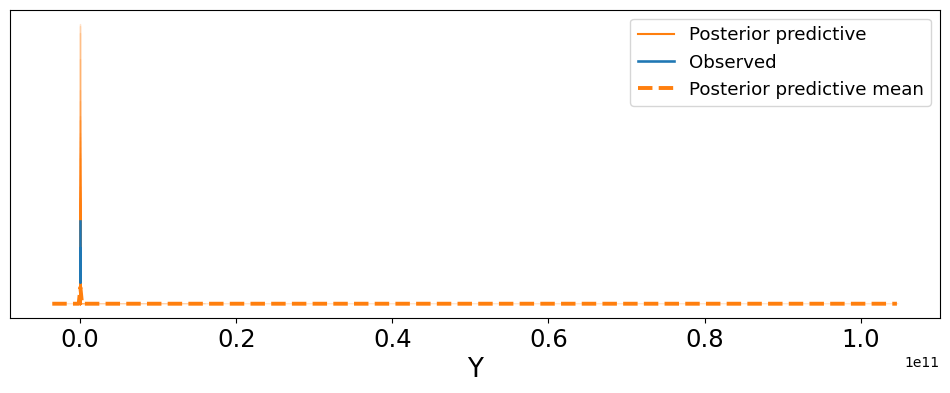

In [11]:
with pm.Model() as model: # another likelihood I tried
    μ = pm.Uniform('μ', lower=36000, upper=42000)

    σ = pm.HalfNormal('σ', sigma=300)

    ν = pm.HalfNormal('ν', sigma=300)

    Y = pm.StudentT('Y', mu = μ, sigma = σ, nu=ν, observed=data)
    idata = pm.sample()

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])